# 时间序列预测之ARIMA

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.style.use('ggplot')

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data=pd.read_csv('soybean_price_guangdong.csv',parse_dates=['date'],index_col=['date'])
data.index=pd.to_datetime(data.index)

In [3]:
data.head()

,price
date,
2010-01-04,8150
2010-01-05,8150
2010-01-06,8150
2010-01-07,8100
2010-01-08,8000


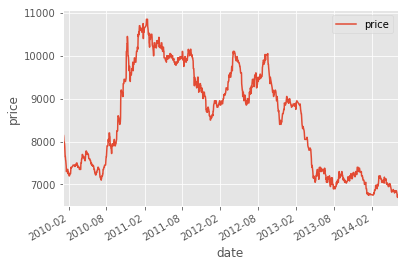

In [4]:
data.plot()
plt.ylabel('price')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1351 entries, 2010-01-04 to 2014-06-06
Data columns (total 1 columns):
price    1351 non-null int64
dtypes: int64(1)
memory usage: 21.1 KB


In [6]:
ts=data['price']
ts.head()

date
2010-01-04    8150
2010-01-05    8150
2010-01-06    8150
2010-01-07    8100
2010-01-08    8000
Name: price, dtype: int64

In [7]:
ts.head().index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08'],
              dtype='datetime64[ns]', name=u'date', freq=None)

In [8]:
ts['2014']

date
2014-01-02    7050
2014-01-03    6980
2014-01-04    6900
2014-01-06    6900
2014-01-07    6850
2014-01-08    6780
2014-01-09    6800
2014-01-10    6800
2014-01-13    6760
2014-01-14    6780
2014-01-15    6800
2014-01-16    6750
2014-01-17    6750
2014-01-20    6780
2014-01-21    6780
2014-01-22    6780
2014-01-23    6760
2014-01-24    6770
2014-02-07    6750
2014-02-10    6800
2014-02-11    6780
2014-02-12    6800
2014-02-13    6830
2014-02-14    6870
2014-02-17    6870
2014-02-18    6900
2014-02-19    6980
2014-02-20    6930
2014-02-21    6950
2014-02-24    6930
              ... 
2014-04-23    6950
2014-04-24    6950
2014-04-25    7000
2014-04-28    7020
2014-04-29    6980
2014-04-30    7000
2014-05-05    6880
2014-05-06    6830
2014-05-07    6830
2014-05-08    6820
2014-05-09    6840
2014-05-12    6850
2014-05-13    6850
2014-05-14    6880
2014-05-15    6880
2014-05-16    6850
2014-05-19    6850
2014-05-20    6820
2014-05-21    6800
2014-05-22    6850
2014-05-23    6850
2014-05

先给出平稳性统计检验函数，可以将一些结果直接展示出来。

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=60)
    rolstd = pd.rolling_std(timeseries, window=60)

    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  after removing the cwd from sys.path.
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).std()
  """


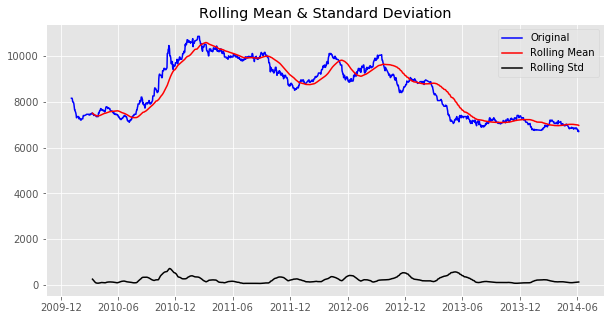

Results of Dickey-Fuller Test:
Test Statistic                   -0.930854
p-value                           0.777642
#Lags Used                       11.000000
Number of Observations Used    1339.000000
Critical Value (5%)              -2.863701
Critical Value (1%)              -3.435243
Critical Value (10%)             -2.567920
dtype: float64


In [10]:
test_stationarity(ts)

这里的test statistic就是检验统计量，p-value是接受原假设的概率，一般情况下按照5%的置信区间去判断就可以。

上面的结果显示，p-value远大于0.05，而且检验统计量大于任何一个critical value，所以并不能拒绝原假设，即非平稳。

# 平稳性处理

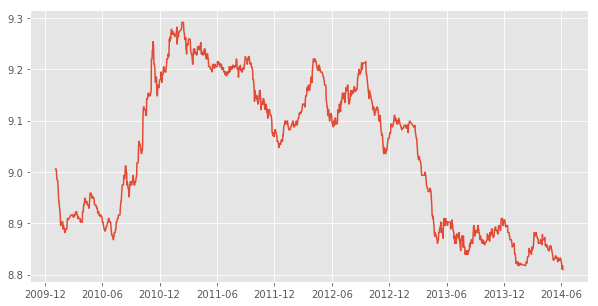

In [11]:
#对数转换

ts_log=np.log(ts)
plt.figure(figsize=(10,5))
plt.plot(ts_log)

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  after removing the cwd from sys.path.
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).std()
  """


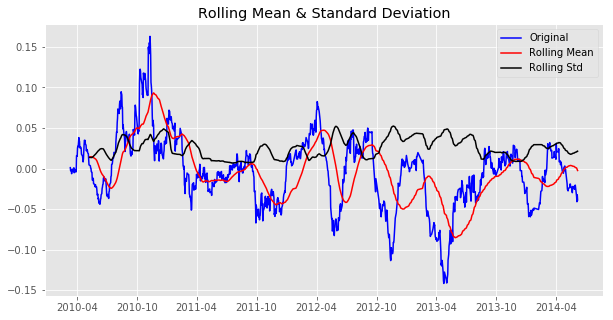

Results of Dickey-Fuller Test:
Test Statistic                   -4.092031
p-value                           0.000998
#Lags Used                       12.000000
Number of Observations Used    1279.000000
Critical Value (5%)              -2.863802
Critical Value (1%)              -3.435473
Critical Value (10%)             -2.567975
dtype: float64


In [12]:
#eliminating trend by moving average
moving_avg=pd.rolling_mean(ts_log,60)
ts_log_moving_avg_diff=ts_log-moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [13]:
#这个图看起来要好一些。Test statistic 比 1% Critical value 要小，而且p-value显著小于0.05，说明在99%置信区间内该序列是一个平稳序列。

#另外，有些情况下，合适的窗口值（如本例中的60）是不太好确定的，所以，可以采用加权移动平均，常用的主要是指数加权移动平均方法，Pandas中用ewma函数。

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=30,min_periods=0,adjust=True).mean()
  """Entry point for launching an IPython kernel.
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  after removing the cwd from sys.path.
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).std()
  """


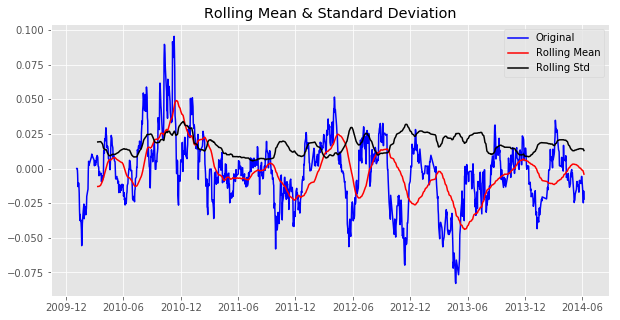

Results of Dickey-Fuller Test:
Test Statistic                   -4.693384
p-value                           0.000087
#Lags Used                        8.000000
Number of Observations Used    1342.000000
Critical Value (5%)              -2.863696
Critical Value (1%)              -3.435232
Critical Value (10%)             -2.567918
dtype: float64


In [14]:
expwighted_avg = pd.ewma(ts_log,span=30)
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  after removing the cwd from sys.path.
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).std()
  """


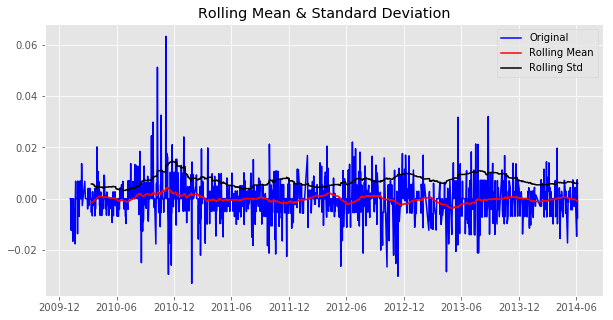

Results of Dickey-Fuller Test:
Test Statistic                -9.508675e+00
p-value                        3.294178e-16
#Lags Used                     1.000000e+01
Number of Observations Used    1.339000e+03
Critical Value (5%)           -2.863701e+00
Critical Value (1%)           -3.435243e+00
Critical Value (10%)          -2.567920e+00
dtype: float64


In [15]:
#差分——差分是剔除周期性因素的最常用方法
#一阶差分可以用Pandas的shift函数
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  after removing the cwd from sys.path.
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).std()
  """


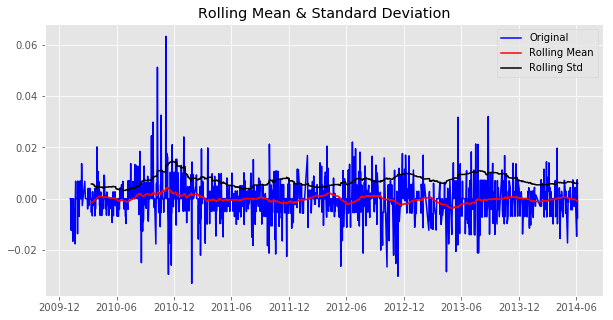

Results of Dickey-Fuller Test:
Test Statistic                -9.508675e+00
p-value                        3.294178e-16
#Lags Used                     1.000000e+01
Number of Observations Used    1.339000e+03
Critical Value (5%)           -2.863701e+00
Critical Value (1%)           -3.435243e+00
Critical Value (10%)          -2.567920e+00
dtype: float64


In [16]:
#另外一种方法做一阶差分
diff_1=ts_log.diff(1)
diff_1.dropna(inplace=True)
test_stationarity(diff_1)

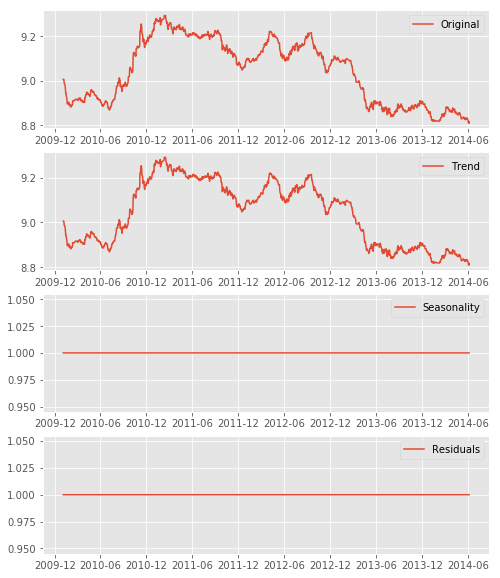

In [17]:
#分解——将时间序列数据分解成不同的成分，例如长期趋势、季节趋势和随机成分

decomposition=seasonal_decompose(ts_log,freq=1,model='multiplicative')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.figure(figsize=(8,10))
plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')

上面把4种方法的具体处理程序都给出了，下面采用一阶差分的结果来建模。

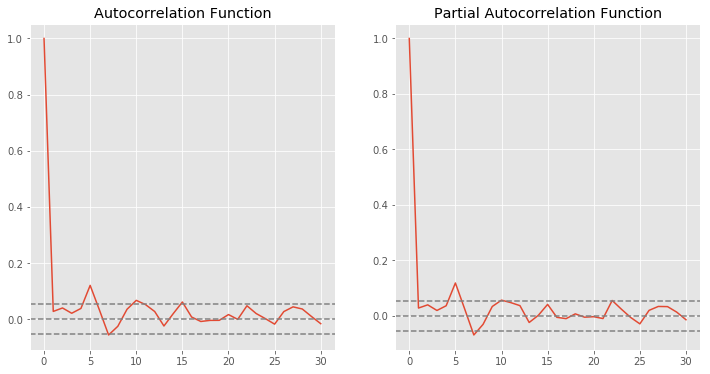

In [18]:
#采用ACF和PACF来确定参数p（AR）和q(MR)
lag_acf=acf(ts_log_diff,nlags=30)
lag_pacf=pacf(ts_log_diff,nlags=30,method='ols')

plt.figure(figsize=(12,6))
#plot_acf
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#plot_pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

什么是截尾和拖尾？

（1）p阶自回归模型 AR(P) 
AR(p)模型的偏自相关函数PACF在p阶之后应为零，称其具有截尾性； 
AR(p)模型的自相关函数ACF不能在某一步之后为零（截尾），而是按指数衰减（或成正弦波形式)，称其具有拖尾性。

（2）q阶移动平均模型 MA(q) 
MA(q)模型的自相关函数ACF在q阶之后应为零，称其具有截尾性； 
MA(q)模型的偏自相关函数PACF不能在某一步之后为零（截尾），而是按指数衰减（或成正弦波形式)，称其具有拖尾性。

判断p和q的值

若都拖尾，得到ARMA(p，q)模型，自相关图有几个在两倍标准差之外就能确定p，偏自相关图突出两倍标准差的确定q。

从ACF和PACF图，可以看出p值为2，q值为2，然后之前做的一阶差分，所以d也为1。

下面就可以按照确定的参数进行模型构造了。

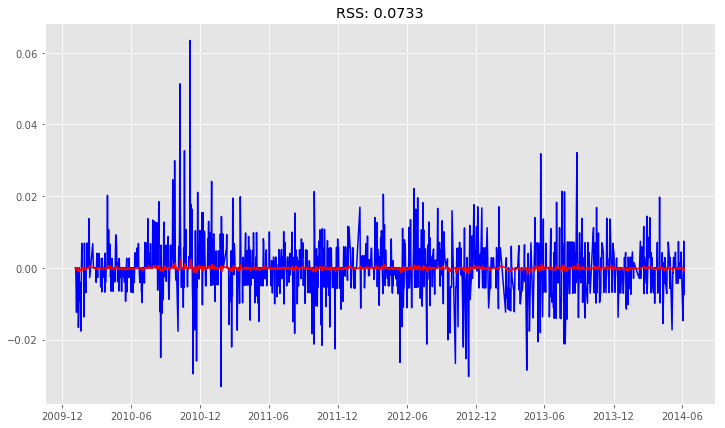

In [19]:
#模型构造
#AR模型

model=ARIMA(ts_log,order=(2,1,0))
results_AR=model.fit()
plt.figure(figsize=(12,7))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

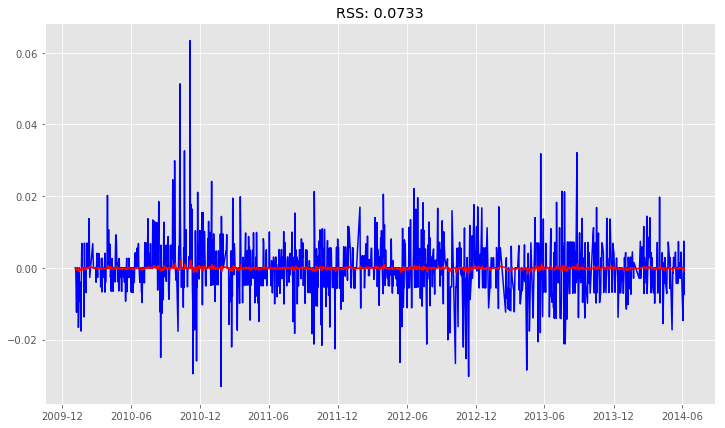

In [20]:
#MA 模型

model=ARIMA(ts_log,order=(0,1,2))
results_MA=model.fit()
plt.figure(figsize=(12,7))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

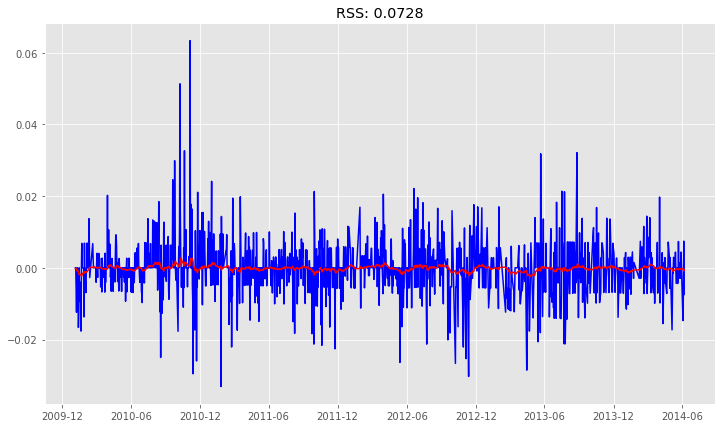

In [21]:
#ARIMA模型

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(12,7))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


In [22]:
#把所计算的结果转变为原来的尺度

predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

date
2010-01-05   -0.000170
2010-01-06   -0.000163
2010-01-07   -0.000157
2010-01-08   -0.000384
2010-01-09   -0.000822
dtype: float64

In [23]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2010-01-05   -0.000170
2010-01-06   -0.000333
2010-01-07   -0.000490
2010-01-08   -0.000874
2010-01-09   -0.001697
dtype: float64

In [24]:
predictions_ARIMA_log=pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


date
2010-01-04    9.005773
2010-01-05    9.005603
2010-01-06    9.005440
2010-01-07    9.005283
2010-01-08    9.004899
dtype: float64

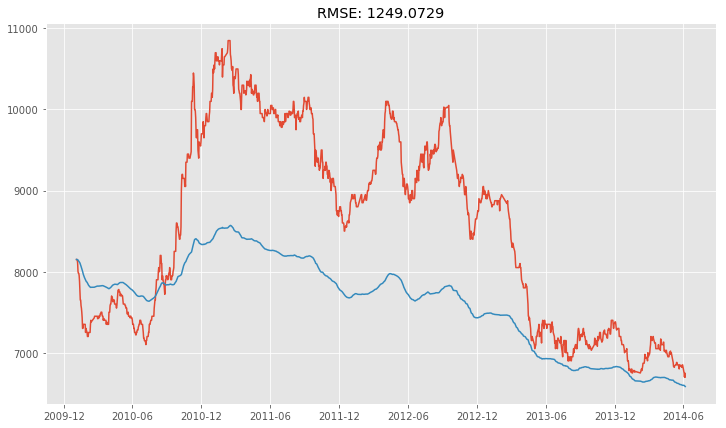

In [25]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.figure(figsize=(12,7))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

另外，也可以让模型来自行识别参数，下面这个函数就是整个过程。

In [26]:
#模型自动识别的参数
import sys
d=1
def proper_model(data_ts, maxLag):
    init_bic = sys.maxint
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARIMA(data_ts, order=(p,d,q))
            try:
                results_ARIMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARIMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARIMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel
proper_model(ts_log_diff,7)

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed 

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimizat

(-9395.1739497803737,
 0,
 1,
 <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x113f10850>)

/Users/xiaoyuan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


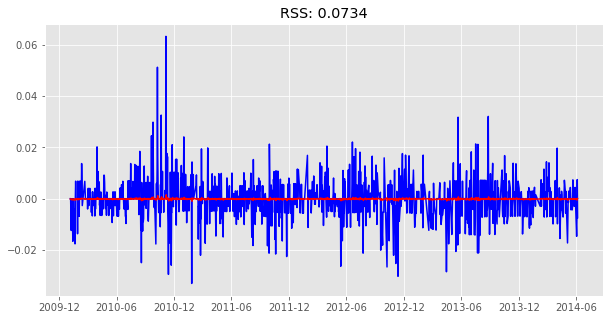

In [27]:
#ARIMA模型

model = ARIMA(ts_log, order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(10,5))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

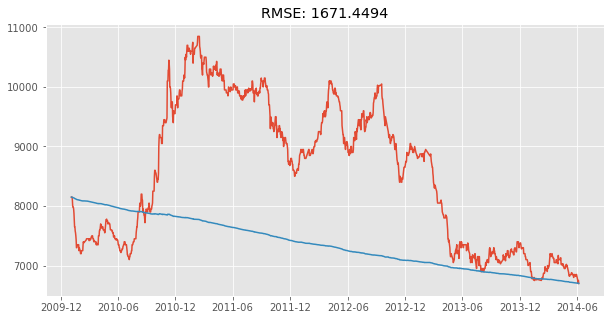

In [28]:
predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log=pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))